**Updated excerpt from [EvidationDataScienceModule](https://github.com/evidation-health/EvidationDataScienceModule)**

# Summary

*Author: Benjamin Bradshaw*

A *huge* piece of whether or not an inferential or predictive project is successful is whether or not the correct information is included in the model. Often times when dealing with IoT data, the raw signal collected from a device is not appropriate for direct input into the model. For example, if we were interested in using step data on a given day to predict whether or not that day was recorded on a weekday or a weekend, including each minute's step count for that day would result in 1440 features (machine learnign verbiage for variables). Unless we had a large amount of data to learn from and fed the raw signal into a complex model such as a neural network (which is possible these days) that might not be th ebest approach. A more labor intensive approach in a data constrained environment might be to conduct what is known as *feature engineering*.

*Feature engineering* consists of taking raw data inputs and transforming them into such a way that extracts more signal, or captures specific characteristics of the data that are important for the task at hand. Feature engineering is not easy- mostly because it requires creativity on the part of *you* the practitioner to deeply understand the problem you are trying to solve, and then engineer features that allow a machine learning model to capture those characteristics. A large part of the preliminary detective work required for successful feature engineering comes in the form of *exploratory data analysis* which is just a fancy word for looking at the data and determining what aspects are important to capture in order to successfully extract the signal pertaining to your project.

This notebook will cover the following topics:
- Using exploratory data analysis (EDA) to identify useful aspects of the data that assist in our analysis task
- Engineer features that capture the patterns identified during EDA

In order motivate these tasks we construct the following prediction task: Can we utilize the accelerometer data in conjuction with other data available through NHANES to differentiate data collected on a weekday compare to data collected on a weekend?

# Learning objectives

By the time you work through this notebook you should be able to:
- Understand the need for splitting our data into a training and testing set when implementing a classification task, as well as how to correctly split our data depending on the use case at hand
- Use some of the basic libraries used in pythn for EDA including pandas, matplotlib, and seaborn
- Build basic software that allows efficient scaling of data analysis
- Understand how features may be extracted from raw accelerometer data for the purpose of a classification task

# Initialize

Dependencies. . . 

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import utils # Utility functions containained in ./utils/
import scipy
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('max.rows', 100)
pd.set_option('max.columns', 100)
sns.set_style('darkgrid')

# Change this location to the path where you would like your data saved to
data_dir = './data/'

# Path to hdf store we will create later
hdf_path = 'nhanes_data.h5'

In [4]:
! [ -d {data_dir} ] && echo "{data_dir} exists" || echo "create {data_dir}" && mkdir {data_dir}
! wget https://ucsb.box.com/shared/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5 -O {data_dir}{hdf_path}

--2020-05-20 07:37:01--  https://ucsb.box.com/shared/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5
Resolving ucsb.box.com (ucsb.box.com)... 107.152.25.197
Connecting to ucsb.box.com (ucsb.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5 [following]
--2020-05-20 07:37:01--  https://ucsb.box.com/public/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5
Reusing existing connection to ucsb.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ucsb.app.box.com/public/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5 [following]
--2020-05-20 07:37:01--  https://ucsb.app.box.com/public/static/dqxggagq4n3hudm4mwaki4vj9d03m4av.h5
Resolving ucsb.app.box.com (ucsb.app.box.com)... 107.152.25.199
Connecting to ucsb.app.box.com (ucsb.app.box.com)|107.152.25.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.c

In [5]:
# Decide whether to use the full raw dataset
# or the sample. THe raw makes the UCSB machines
# explode, so unless you are using a beefier 
# machine I would recommend setting using_sample
# to True

using_sample = True

In [6]:
# Load cleaned accelerometer data from last time
if using_sample:
    %time pax = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_clean_sample')
else:
     %time pax = pd.read_hdf(os.path.join(data_dir, hdf_path), 'pax_clean')

CPU times: user 302 ms, sys: 122 ms, total: 425 ms
Wall time: 423 ms


In [7]:
# Remove 'pax' prefix on column names: it was getting annoying
pax.columns = [x.split('pax')[1] if 'pax' in x else x for x in pax.columns]

In [8]:
pax.head()

,seqn,stat,day,n,hour,minut,inten,step,minute_of_day
0,31151.0,1,1,1,0,0,0,0.0,0
1,31151.0,1,1,2,0,1,0,0.0,1
2,31151.0,1,1,3,0,2,0,0.0,2
3,31151.0,1,1,4,0,3,0,0.0,3
4,31151.0,1,1,5,0,4,0,0.0,4


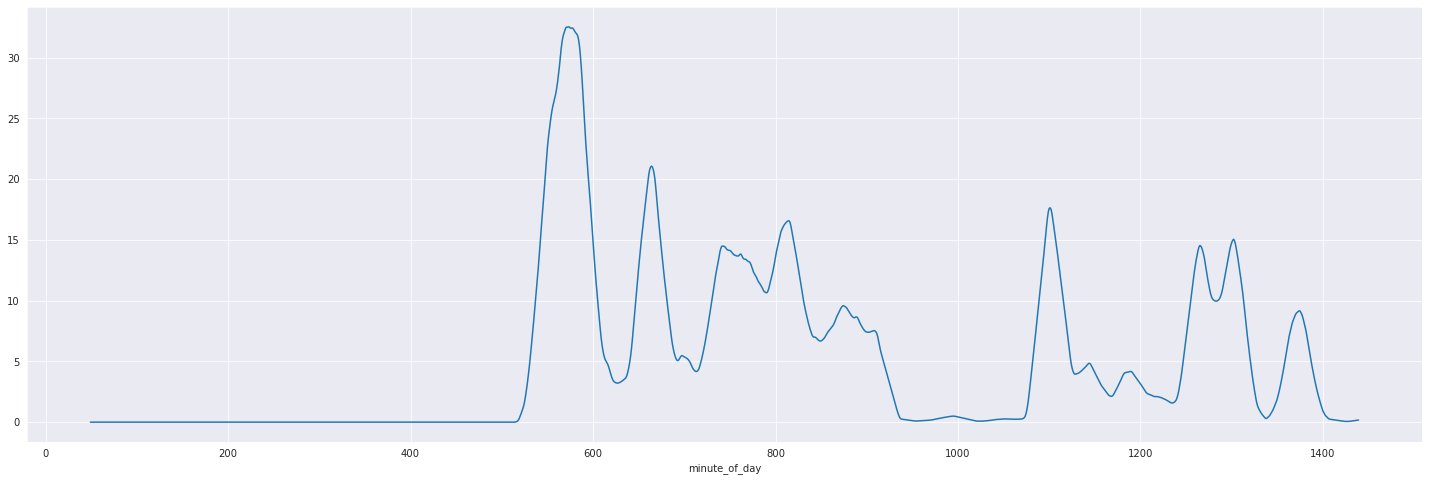

In [9]:
test_id = pax.seqn.values[1]
pax_sample = pax[pax.seqn==test_id].copy()

# Plot the 30-minute rolling walk step series for our sampled user over day 1
pax_sample[pax_sample.day==1]\
    .set_index('minute_of_day')\
    .step.rolling(window=50, win_type='triang')\
    .mean()\
    .plot(figsize=(25,8))
    
# Note: I'm using the line continuation character \ in conjunction with
# method chaining here.

## Exercise: Plotting user day series

Using the example code above, define a function ```plot_user_steps()``` that takes 4 arguments as input and plots a specific user's rolling walk step plot simialr to the plot shown above. The function's arguments should be:
1. ```pax_df``` (pandas dataframe) The physical activity dataframe
2. ```seqn_id``` (str) The unique study participant id
3. ```day_of_study``` (int) The day of the study to plot
4. ```window_len``` (int) The window length to use for the moving average.

The function should then plot the rolling walk series for a specific user, for a specific day. As a bonus, build in functionality so that passing ```None``` to the parameter ```seqn_id``` will default to choosing a random id from the set of seqn ids and using that to create the plot.

**Side Note: Building Data Science Tools**
A lot of what practicing data scientists do on a daily basis revolves around building tools that solve specific problems pertaining to an analysis. In fact, some may argue that's what seperates a data scientist from your everyday analyst. During this module we really want to encourage you to build tools that make analysis scale. In the process you may even find that it can be very fun and rewarding to create a useful suite of analysis tools to speed up your workflow!

In [10]:
######################
# YOUR SOLUTION HERE #
######################

## Solution: Plotting user day series

We wrote a little snippet of code that implements the solution above. If you are curious how we did it, take a look in the ```utils``` folder that was imported at the top of the notebook.

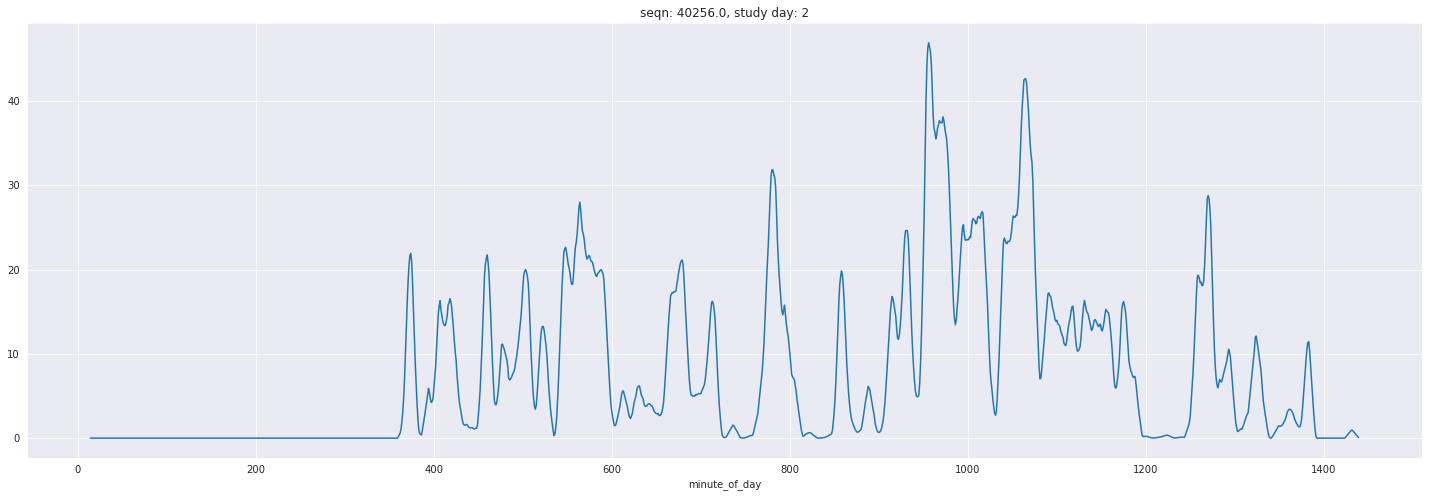

In [11]:
def plot_user_steps(pax_df, seqn_id=None, day_of_study=1, window_len=30):
    """
    Plot a single user-day's walk step intensity values.
    
    Inputs:
        pax_df (Pandas DataFrame): DataFrame of all user 
        step data
        seqn_id (str): If not None, plot this specific user's 
        step intensity
        day_of_study (int): Day of study to plot
        window_len (int): Choice of rolling window for walk 
        step intensity
        
    Returns:
        None. Plots user walk steps inline in notebook.
    """
    if seqn_id is None:
            seqn_id = np.random.choice(pax_df[pax_df.day==day_of_study].seqn.unique(), 1)[0]
    plt_df = pax_df[(pax_df.seqn==seqn_id) & (pax_df.day==day_of_study)]
    try:
        assert len(plt_df) == 1440 # Make sure there are 1440 rows in the dataframe
    except AssertionError as e:
            e.args += (
                """
                Error: Unexpected number of rows returned: ({})
                when using parameters seqn_id={} 
                and day_of_study={}, expected 1440
                """.format(len(plt_df), seqn_id, day_of_study), )
            raise
    plt_df.set_index('minute_of_day', inplace=True)
    plt_df.step.rolling(
        window=window_len,
        win_type='triang'
    ).mean().plot(figsize=(25,8), title='seqn: {}, study day: {}'.format(seqn_id, day_of_study))

plot_user_steps(pax, None, 2, 15)

# The need for a training and testing set

Traditional statistics often times is concerned with creating *estimators* that are unbiased or perhaps consistent estimates of some true population parameter $\theta$. In this setting it is common to "fit" an estimator (e.g. linear/logistic regression etc) to the *entire* sample of data. In this setting this choice makes sense, since we seek to minimize the difference between $\theta$ and $\hat{\theta}$ (our estimated parameter). Certain estimators have guarantees about unbiasedness, and we maximize our statistical power when we use the entire sample to fit the model (think about what happens to the standard errors of the OLS coefficients as $n \rightarrow \infty$). However, at the end of the day an inferential analysis always suffers from doubt: apart from collecting a second (or third, or fourth) sample, we have no bullet proof way to check how robust our results are.

In a *prediction* setting our goal is quite different. Given a set of inputs $X$ we want our model to do a "good" job of minimizing the "difference" between the actual label associated with that input $y$ and the predicted label the model produces $\hat{y}$. Because this is our goal, we have a very powerful tool on our side to asses whether or not our model is "good". The tool is conceptually very simple and easy to understand: we will split our training set into two sets: a "training" set and a "testing" set. The training set will be used for all exploratory work, model training, model selection, hyperparameter tuning etc. The testing set will be set aside, completely quarantined from our development process, and only used once our model is entirely finished. At that point, we will use our model to compute predictions over the test set and we will use these predictions to assess just how good our model would have been "out in the wild" when making predictions on unseen examples.

Constructing a test set is conceptually simple, but it is fraught with danger in implementation. How you construct this split requires careful forethought about the goal of the task, as well as attention to the details that might imperil the generalizeability of your model.

In this section we will construct a train-test split of our dataset, walking through some of the common issues that you might want to consider when building a pipeline of your own.

## Creating a testing-training split

Let's get into the details of creating a train-test split. First we need to decide what the classification use case is. We know we are trying to classify weekdays and weekend days, but do we want our model to generalize to *new unseen people* or do we want our model to generalize to *new unseen days* on the same people. There is a subtle distinction between those two cases. In the first case, we would want to make sure people observed in our training set are not observed in our test set in order to ensure we simulate the ability to generalize to new people. In the second case it's actually OK if the same people show up in both the training and testing splits: we are training the model to learn individual specific patterns and behaviors.

For this analysis let's say our goal is option 1: generalize to new people. Since this is the case we need to ensure that days from people in our chosen training set do not also end up in our test set. We'll also want to ensure that the statistical properties of our training set match that of our test set as closely as possible. 

We'll start by taking a look at the demographic table found in NHANES. We'll then conduct the following steps:
- Filter the demographics table to only include participants who also exist in the pax table
- Conduct stratified sampling on age/gender/other important characteristics?

## Examining the demographic dataset

In order to create a proper train-test split we'll first do soem exploration of the NHANES demographic table. Let's go ahead and read it in from our hdf store.

In [12]:
# Recall in the last notebook we read this from the NHANES website
demo_df = pd.read_hdf(os.path.join(data_dir, hdf_path), 'demographics_with_sample_weights')

# Recast seqn to object type for joining later
demo_df['seqn'] = demo_df.seqn.astype(str)

# Only keep participants who also have physical activity data
demo_df = demo_df[demo_df.seqn.isin(pax.seqn.unique())]

# Peek inside
demo_df.head()

,seqn,sddsrvyr,ridstatr,ridexmon,riagendr,ridageyr,ridagemn,ridageex,ridreth1,dmqmilit,dmdborn,dmdcitzn,dmdyrsus,dmdeduc3,dmdeduc2,dmdschol,dmdmartl,dmdhhsiz,dmdfmsiz,indhhinc,indfminc,indfmpir,ridexprg,dmdhrgnd,dmdhrage,dmdhrbrn,dmdhredu,dmdhrmar,dmdhsedu,sialang,siaproxy,siaintrp,fialang,fiaproxy,fiaintrp,mialang,miaproxy,miaintrp,aialang,wtint2yr,wtmec2yr,sdmvpsu,sdmvstra
24,31151.0,4.0,2.0,1.0,2.0,59.0,711.0,711.0,4.0,2.0,1.0,1.0,NaN,NaN,3.0,NaN,1.0,2.0,2.0,7.0,7.0,3.03,2.0,1.0,60.0,1.0,4.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,32632.519543,32058.654021,2.0,53.0
62,31189.0,4.0,2.0,1.0,2.0,9.0,111.0,112.0,5.0,NaN,1.0,1.0,NaN,2.0,NaN,1.0,NaN,4.0,4.0,8.0,8.0,2.58,2.0,1.0,38.0,1.0,3.0,NaN,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,13399.023449,13980.278478,1.0,56.0
117,31244.0,4.0,2.0,2.0,1.0,23.0,280.0,281.0,3.0,2.0,1.0,1.0,NaN,NaN,5.0,NaN,6.0,2.0,2.0,6.0,6.0,2.16,NaN,2.0,21.0,1.0,5.0,NaN,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,84964.347933,90841.262150,2.0,48.0
206,31333.0,4.0,2.0,1.0,2.0,29.0,353.0,354.0,1.0,2.0,1.0,1.0,NaN,NaN,4.0,NaN,5.0,2.0,2.0,7.0,7.0,3.12,2.0,2.0,29.0,1.0,4.0,5.0,NaN,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,21509.385526,22069.696080,1.0,56.0
221,31348.0,4.0,2.0,1.0,1.0,62.0,745.0,746.0,4.0,2.0,1.0,1.0,NaN,NaN,2.0,NaN,1.0,2.0,2.0,11.0,11.0,5.00,NaN,2.0,57.0,1.0,5.0,1.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0,12164.197913,12460.766885,1.0,49.0


What in the world? What are all the cryptic column names?? Well, the CDC has chosen somewhat unhelpful names that map to demographic characteristics of participants. We *could* go to the website that lists the variable names and keep track of them. However, if we are clever there might be a better way. . . .The pandas library makes it easy to scrape tables via a url. All we need is the url where the table is located, as well as the index of the xml blob we are interested in.

In [13]:
demo_metadata_url = 'https://wwwn.cdc.gov/nchs/nhanes/search/variablelist.aspx?Component=Demographics&CycleBeginYear=2005'
idx = 0 # I looked up the blob I was interested in in advance

# Create demographic metadata DataFrame
demo_metadata = pd.read_html(demo_metadata_url)[idx]

# Filter metadata to just include the demographics table
demo_metadata = demo_metadata[demo_metadata['Data File Name']=='DEMO_D']

# Peek inside
demo_metadata.head()

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear,Component,Use Constraints
0,AIALANG,Language of the MEC ACASI Interview Instrument,DEMO_D,Demographic Variables & Sample Weights,2005,2006,Demographics,None
1,DMDBORN,In what country {were you/was SP} born?,DEMO_D,Demographic Variables & Sample Weights,2005,2006,Demographics,None
2,DMDCITZN,{Are you/Is SP} a citizen of the United States...,DEMO_D,Demographic Variables & Sample Weights,2005,2006,Demographics,None
3,DMDEDUC2,(SP Interview Version) What is the highest gra...,DEMO_D,Demographic Variables & Sample Weights,2005,2006,Demographics,None
4,DMDEDUC3,(SP Interview Version) What is the highest gra...,DEMO_D,Demographic Variables & Sample Weights,2005,2006,Demographics,None


The meta table we just created gives us the mapping from column names in our raw data to human readable descriptions. Unfortunately it doesn't give us what the variable facto levels correspond to. For this we will need to go to [this site](https://wwwn.cdc.gov/nchs/nhanes/2005-2006/DEMO_D.htm) to parse out each variable of interest.

In [14]:
# Map numeric gender attributes to human readable
gender_factor_levels = {
    1: 'male',
    2: 'female'
}

# Map numeric ethnicity values to human readable
race_factor_levels = {
    1: 'mexican_american',
    2: 'other_hispanic',
    3: 'non_hispanic_white',
    4: 'non_hispanic_black',
    5: 'other_race'
}

# Map in school ethnicity values to human readable
school_factor_levels = {
    1: 'in_school',
    2: 'on_vacation_from_school',
    3: 'between_grades',
    -1: 'unknown'
}

Let's do some quick summary plots on age, gender and school status, since these seem like a good set of variables to stratify on.

Text(0.5, 0, 'Age')

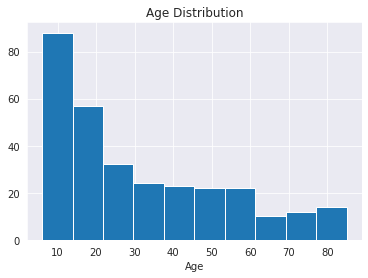

In [15]:
demo_df.ridageyr.hist()
plt.title('Age Distribution')
plt.xlabel('Age')

Looks like we will definitely want to bin age and stratify given that weekend behavior may vary extensively between age brackets.

In [16]:
# Recode missing values to something we can map a value to
demo_df['dmdschol'] = demo_df.dmdschol.fillna(-1)

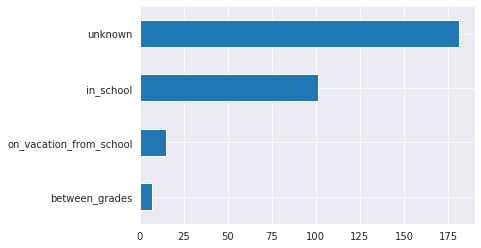

In [17]:
# Check out the distribution of school vs not school
# My hypothesis here is that kids in school have much different sleep patterns
# than those who aren't in school
demo_df.dmdschol.map(school_factor_levels).value_counts().sort_values().plot(kind='barh')

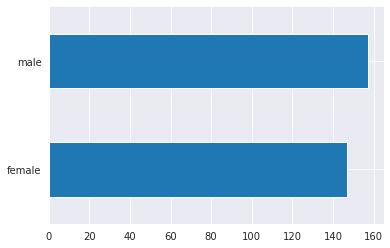

In [18]:
# Distribution of male/female
demo_df.riagendr.map(gender_factor_levels).value_counts().sort_values().plot(kind='barh')

# Implementing the train-test split

In this section we will actually implement our train-test split with stratification. We will first stratify our sample by (1) age bin, (2) gender, and (3) school status.

In [19]:
# Create age bins
age_bins = [x*10 for x in range(10)]
# Create a new variable that designates an age in years to an age bin
demo_df['age_bin'] = pd.cut(demo_df.ridageyr, bins=age_bins)

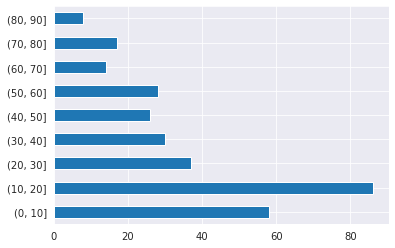

In [20]:
demo_df.age_bin.value_counts().sort_index().plot(kind='barh')

In [21]:
# Specify our test proportion
test_frac = 0.2

# Conduct random stratified sampling and get a set of test ids
test_ids = demo_df.groupby(['riagendr', 'dmdschol', 'age_bin'])
test_ids = test_ids.apply(lambda df: df.sample(frac=test_frac)).seqn.unique()

In [22]:
# Check everything worked out
test_frac == (len(test_ids) / demo_df.seqn.nunique())

False

In [23]:
# Next, extract train ids
train_ids = demo_df[~demo_df.seqn.isin(test_ids)].seqn.unique()

# QC check
(1-test_frac) == len(train_ids) / demo_df.seqn.nunique()

False

In [24]:
# One last sanity check
len(set(train_ids).intersection(set(test_ids))) == 0

True

Now that we have a set of disjoint train and test ids, we can return to the activity data in order to construct a train-test split.

In [25]:
# Create our training set
train_pax = pax.merge(
    demo_df.loc[demo_df.seqn.isin(train_ids), ['seqn']],
    how='inner',
    on='seqn'
)

In [26]:
# Create our testing set
test_pax = pax.merge(
    demo_df.loc[demo_df.seqn.isin(test_ids), ['seqn']],
    how='inner',
    on='seqn'
)

In [27]:
# Does the distribution of coverage over days seem reasonable
# between train and test?
train_pax.groupby('day').seqn.nunique() / len(train_ids)

day
1    0.562500
2    0.833333
3    0.875000
4    0.879167
5    0.841667
6    0.783333
7    0.579167
Name: seqn, dtype: float64

In [28]:
test_pax.groupby('day').seqn.nunique() / len(test_ids)

day
1    0.578125
2    0.750000
3    0.812500
4    0.718750
5    0.859375
6    0.750000
7    0.640625
Name: seqn, dtype: float64

# Building useful features

In this section we are going to dive into the meat of engineering features using the raw physical activity data that will be used as inputs into our weekday-weekend classifier. Although it might initially be suprising, there is quite a bit of useful information that can extracted from the minute level into day level features. The first step in feature engineering is seeing what facets of your data correspond to the outcome of interest. In order to do that, we will begin with some exploratory data analysis (EDA).

Note that in the physical activity dataset day of week is encoded as 1 => Sunday, 2 => Monday, . . .

In [29]:
# Create our target variable map
weekend_map = {x: 1 if (x==1 or x==7) else 0 for x in range(1, 8)}

# Map weekday variable to binary outcome
train_pax['is_weekend'] = train_pax.day.map(weekend_map)

As a very basic first pass, let's just look at some high level aggregates over days to see if we can observe differences between weekend and week days.

In [30]:
# Day level summary statistics computed over minute level steps
daily_aggs = train_pax.groupby(['seqn', 'day']).agg({x: ['mean', 'std', 'max'] for x in ['step', 'inten']})

In [31]:
# Reset columns
agg_cols = ['seqn', 'day', 'steps_mean', 'steps_std', 'steps_max', 'inten_mean', 'inten_std', 'inten_max']
daily_aggs = daily_aggs.reset_index()
daily_aggs.columns = agg_cols

In [32]:
daily_aggs['is_weekend'] = daily_aggs.day.map(weekend_map)

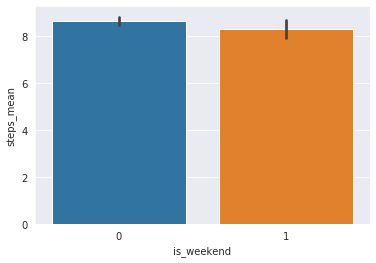

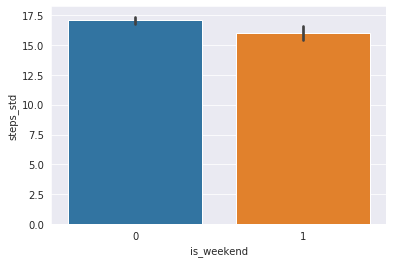

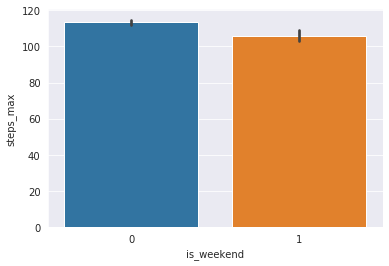

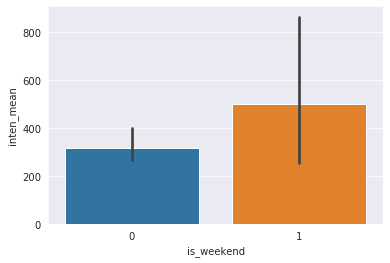

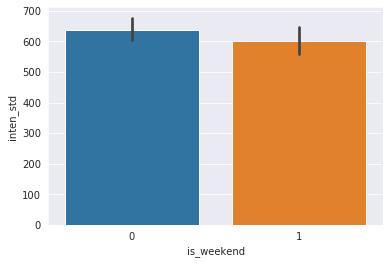

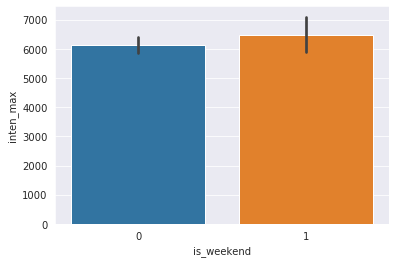

In [33]:
features = ['steps_mean', 'steps_std', 'steps_max', 'inten_mean', 'inten_std', 'inten_max']

for i, feat in enumerate(features):
    plt.figure(i)
    sns.barplot(y=feat, x='is_weekend', data=daily_aggs)

You can see that even with these very basic features there is some class discrimination happeing here. In general, people walk less on weekend than they do on weekdays: both averaging across minutes as well as choosing the maximum minute of the day. Let's look at the entire distribution of mean steps for both classes.

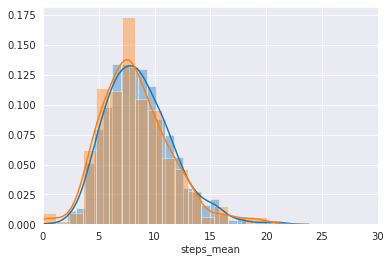

In [34]:
for day_type in [0, 1]:
    sns.distplot(
        daily_aggs.loc[(daily_aggs.is_weekend==day_type) & (~daily_aggs.steps_mean.isnull()), 'steps_mean']
    )
    plt.xlim((0, 30))

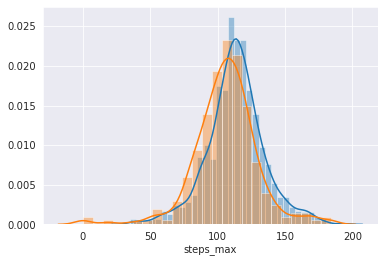

In [35]:
for day_type in [0, 1]:
    sns.distplot(
        daily_aggs.loc[(daily_aggs.is_weekend==day_type) & (~daily_aggs.steps_mean.isnull()), 'steps_max']
    )

You can see there definitely is *some* class separation: it isn't great, but it's a start! We are going to need to get more creative with our feature engineering. For better or for worse, many machine learning problems (especially in healthcare) require domain knowledge. The same is true of this problem: we need to creatively think about what factors may discriminate between weekdays and weekends. Let's brainstorm a few features:
- Index of first minute walked during the day
- Index of last minute walked during the day
- Max steps walked during a minute of the day
- Sum of steps walked during the day
- % of minutes during a day where steps walked > 0

In [36]:
def first_step_minute(s):
    """
    Compute the first observed step index within a user-day.
    """
    nonzero_step_idx = np.nonzero(s.values)[0]
    if len(nonzero_step_idx) > 0:
        return np.min(nonzero_step_idx)
    return np.nan

def last_step_minute(s):
    """
    Compute the first observed step index within a user-day.
    """
    nonzero_step_idx = np.nonzero(s.values)[0]
    if len(nonzero_step_idx) > 0:
        return np.max(nonzero_step_idx)
    return np.nan

def max_steps(s):
    """
    Return the maximum steps walked in a one minute period during a day
    """
    return s.max()

def sum_steps(s):
    """
    Return the maximum steps walked in a one minute period during a day
    """
    return s.sum()

def pct_nonzero_steps(s):
    """
    Return the percent of days with steps > 0
    """
    nonzero_step_idx = np.nonzero(s.values)[0]
    if len(nonzero_step_idx) > 0:
        return 100*(len(nonzero_step_idx) / len(s))
    return np.nan

def max_rolling_30(s):
    """Compute the maximum 30 minute rolling window sum during a day"""
    return s.rolling(window=30, win_type='triang', min_periods=5).sum().max()

def first_morning_step_minute(s):
    """Compute the first step post 4 am"""
    first_allowable_idx = 60*4 # index corresponding to 4am
    s[:first_allowable_idx] = 0
    nonzero_step_idx = np.nonzero(s.values)[0]
    if len(nonzero_step_idx) > 0:
        return np.min(nonzero_step_idx)
    return np.nan

def feature_computer(df, nodes):
    """Compute all features in nodes over all user-days in df"""
    features = df.groupby(['seqn', 'day']).agg({'step': nodes})
    features.reset_index(inplace=True)
    feat_names = [x[1] for x in features.columns[2:]] 
    features.columns = ['seqn', 'day'] + feat_names
    return features

In [37]:
# The list of features we want to compute
feature_nodes = [
    first_step_minute,
    last_step_minute,
    max_steps,
    sum_steps,
    pct_nonzero_steps,
    max_rolling_30,
    first_morning_step_minute
]

# This takes a few seconds to compute
train_features = feature_computer(train_pax, feature_nodes)
test_features = feature_computer(test_pax, feature_nodes)

In [38]:
train_features['is_weekend'] = train_features.day.map(weekend_map)
test_features['is_weekend'] = test_features.day.map(weekend_map)

In [39]:
train_features.head()

,seqn,day,first_step_minute,last_step_minute,max_steps,sum_steps,pct_nonzero_steps,max_rolling_30,first_morning_step_minute,is_weekend
0,31189.0,2,435.0,1293.0,116.0,12740.0,50.416668,684.233337,435.0,0
1,31189.0,3,427.0,1236.0,142.0,13956.0,47.083332,946.099976,427.0,0
2,31189.0,4,389.0,1242.0,133.0,12091.0,44.791668,886.933350,389.0,0
3,31189.0,6,388.0,1370.0,130.0,14306.0,53.888889,759.533325,388.0,0
4,31244.0,1,9.0,1439.0,128.0,12837.0,37.569443,1059.233276,766.0,1


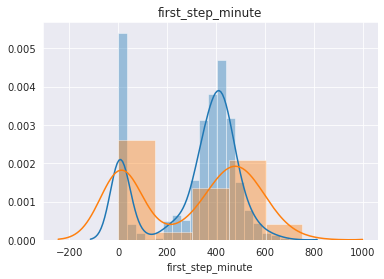

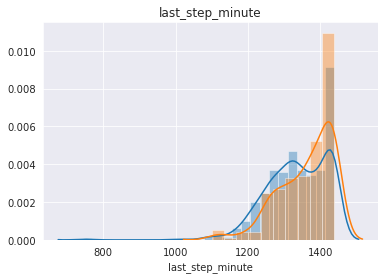

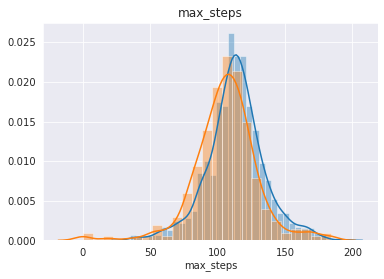

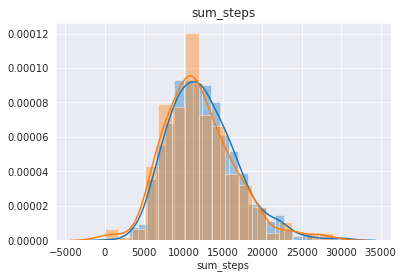

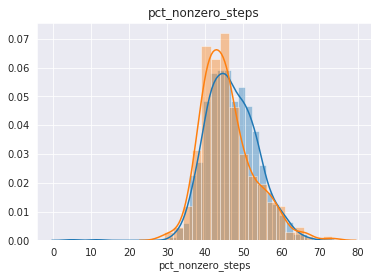

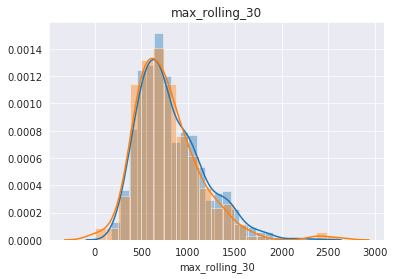

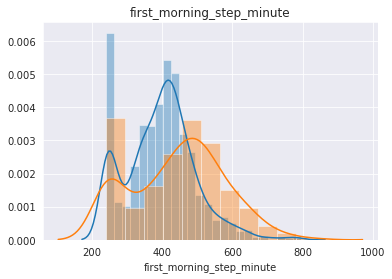

In [40]:
features = ['first_step_minute', 'last_step_minute', 'max_steps', 'sum_steps', 'pct_nonzero_steps', 'max_rolling_30', 'first_morning_step_minute']

for feat in features:
    plt.figure()
    plt.title(feat)
    for day_type in [0, 1]:
        sns.distplot(
            train_features.loc[
                (train_features.is_weekend==day_type) & 
                (~train_features[feat].isnull()), feat
            ]
        )

Some of these features look promising! Specifically first step minute is interesting: it corresponds to when people are waking up in the morning and our intuition tells us that people wake up later on the weekends. It's nice to see that the data supports our prior.

# Joining Datasets

Now that we have built a few promising features, let's add in the demographic features. In order to do that we need to *join* them in. We have already showed you a few joins in action, but now we'll explain a bit more what's going on under the hood. To do this we'll use the following datasets:

- Selected participant demographics
- Physical activity features computed above

There is a 1:1 correspondence between these two tables: specifically each row in both has a unique ```seqn``` value that is also found in the other table. For this join, we will do what is known as an *inner join*. This means that we will specify a join key that exists in both sets, and *only* join those keys that exist in the intersection of the two key sets. For more information on the different types of joins check out [this resource](https://www.w3schools.com/sql/sql_join.asp).

In [41]:
# Keep the following columns:
keep_demo_cols = {'seqn': 'seqn', 'riagendr': 'gender', 'dmdschol': 'currently_in_school', 'dmdhhsiz': 'household_size', 'ridageyr': 'age_in_years'}

# Create a copy of the demo df
demo_keep = demo_df[list(keep_demo_cols.keys())].copy()

# Remap names into something not insane
demo_keep.rename(columns=keep_demo_cols, inplace=True)

In [42]:
# Creating a new DataFrame with pax + demographics
train_analysis_set = train_features.merge(
    demo_keep,
    on='seqn',
    how='inner'
)

test_analysis_set = test_features.merge(
    demo_keep,
    on='seqn',
    how='inner'
)

In [43]:
train_analysis_set.head()

,seqn,day,first_step_minute,last_step_minute,max_steps,sum_steps,pct_nonzero_steps,max_rolling_30,first_morning_step_minute,is_weekend,gender,currently_in_school,household_size,age_in_years
0,31189.0,2,435.0,1293.0,116.0,12740.0,50.416668,684.233337,435.0,0,2.0,1.0,4.0,9.0
1,31189.0,3,427.0,1236.0,142.0,13956.0,47.083332,946.099976,427.0,0,2.0,1.0,4.0,9.0
2,31189.0,4,389.0,1242.0,133.0,12091.0,44.791668,886.933350,389.0,0,2.0,1.0,4.0,9.0
3,31189.0,6,388.0,1370.0,130.0,14306.0,53.888889,759.533325,388.0,0,2.0,1.0,4.0,9.0
4,31244.0,1,9.0,1439.0,128.0,12837.0,37.569443,1059.233276,766.0,1,1.0,-1.0,2.0,23.0


Let's do a bit more visualization in order to understand whether the features we have built do a nice job of class separation. We'll segment by both school status as well as gender and then look at the distribution of first morning step minute and last step minute.

<Figure size 432x288 with 0 Axes>

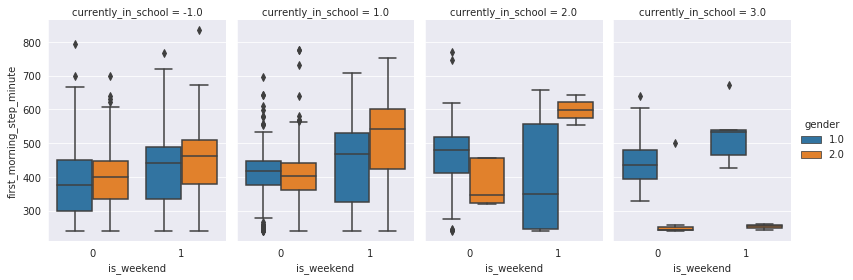

<Figure size 432x288 with 0 Axes>

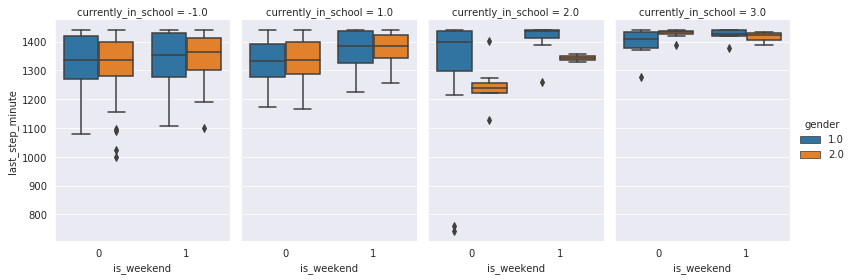

In [44]:
for feat in ['first_morning_step_minute', 'last_step_minute']:
    plt.figure()
    sns.catplot(
        x='is_weekend',
        y=feat,
        hue='gender',
        col='currently_in_school',
        data=train_analysis_set,
        kind='box',
        height=4,
        aspect=.7
    )

In [45]:
school_factor_levels

{1: 'in_school',
 2: 'on_vacation_from_school',
 3: 'between_grades',
 -1: 'unknown'}

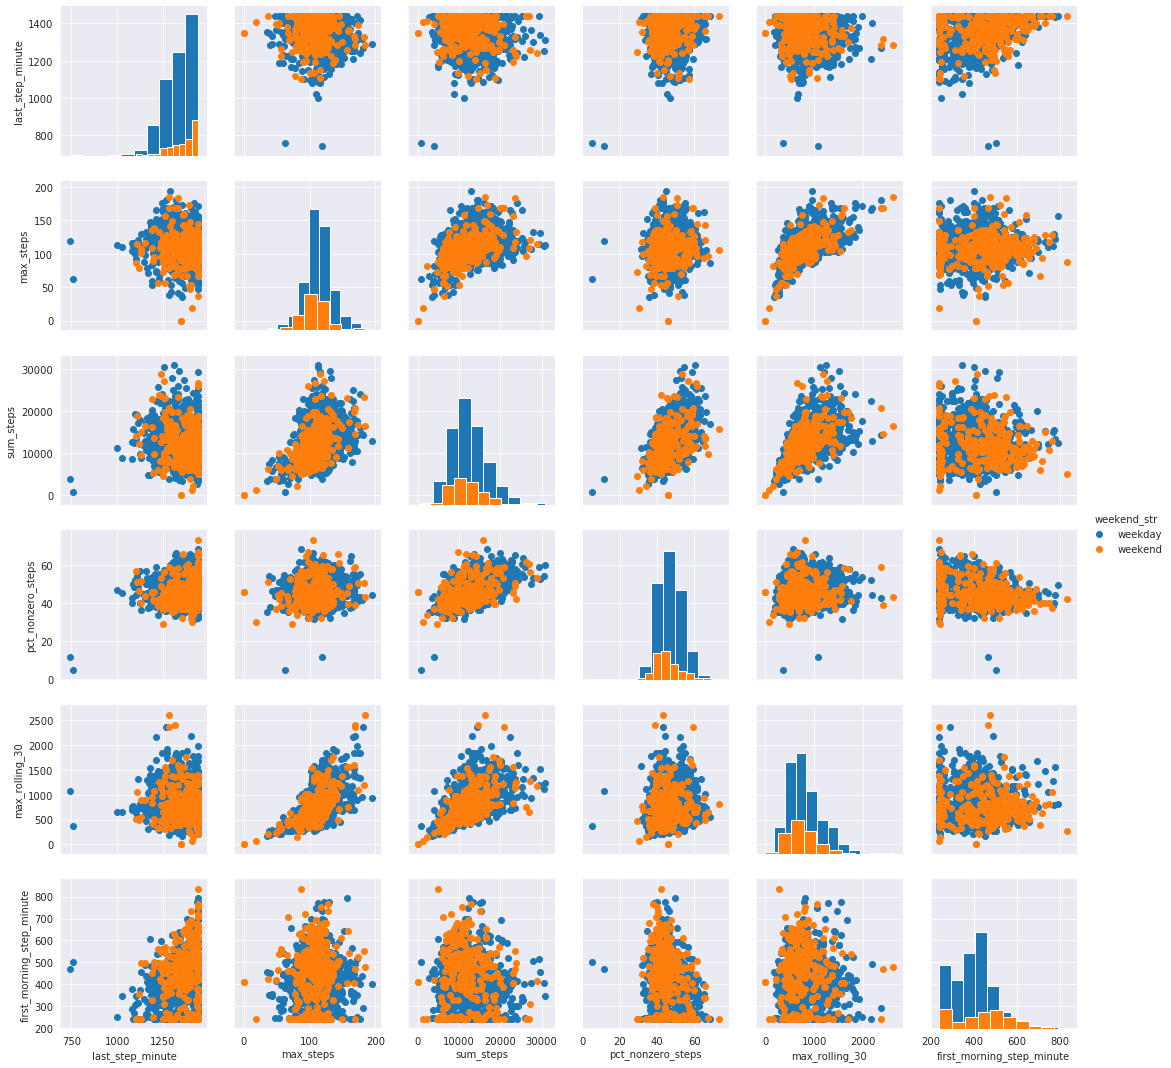

In [46]:
# See how well feature combinations separate our classes in two dimensions

# Add a string version of our label for plotting purposes
train_analysis_set['weekend_str'] = train_analysis_set.is_weekend.map({1: 'weekend', 0: 'weekday'})

# Create a copy of our data for plotting
tmp = train_analysis_set.fillna(train_analysis_set.median())

# Only select activity features
act_feats = ['last_step_minute', 'max_steps', 'sum_steps', 'pct_nonzero_steps', 'max_rolling_30', 'first_morning_step_minute', 'weekend_str']

# Pair plot
g = sns.PairGrid(tmp[act_feats].fillna(tmp[act_feats].median()), hue='weekend_str')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

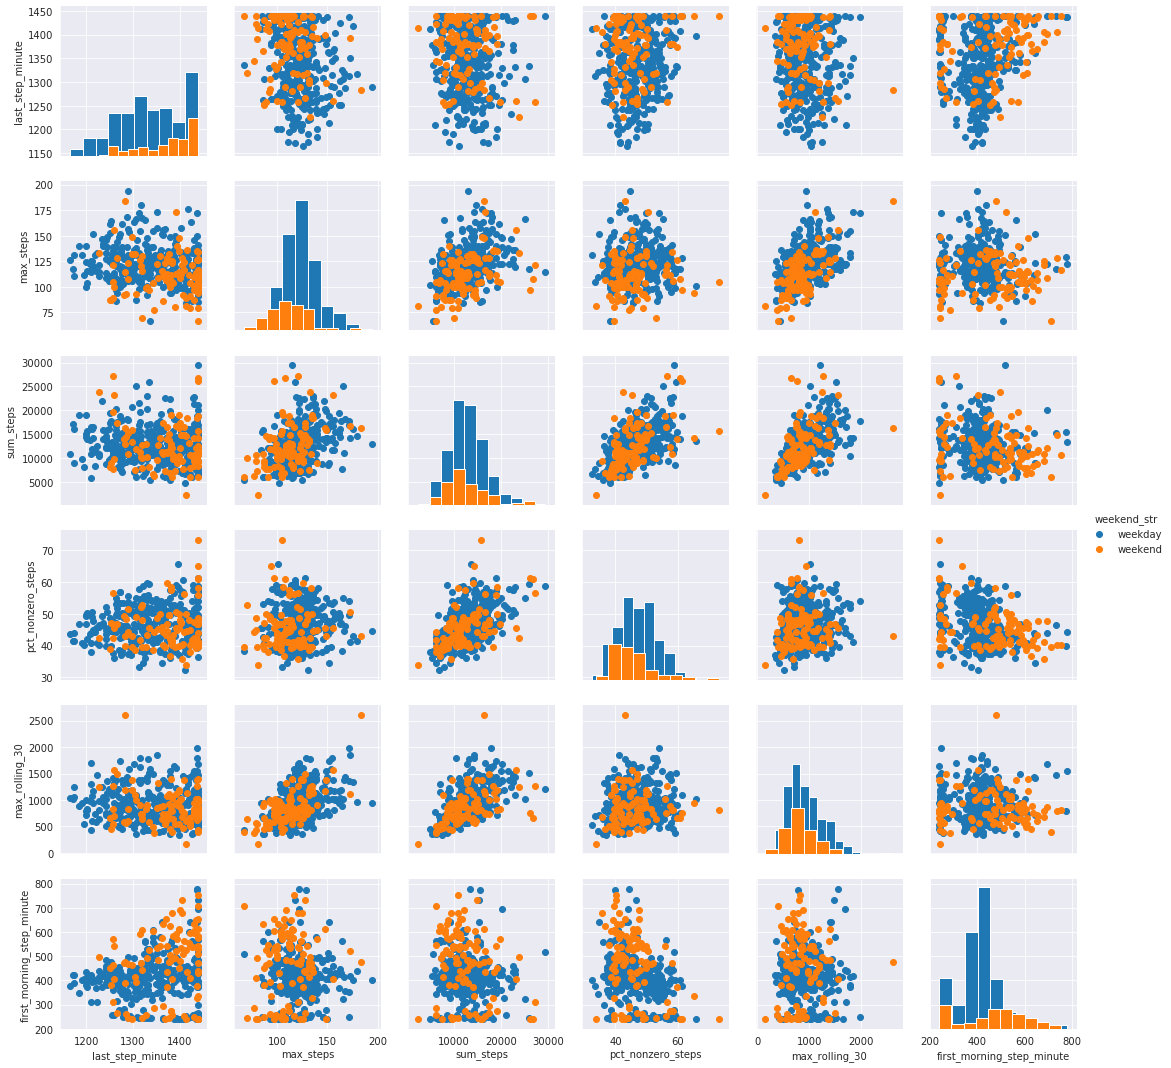

In [47]:
# Same as above but segment by school status

# Pair plot for only participants in school
g = sns.PairGrid(tmp.loc[tmp.currently_in_school==1, act_feats], hue='weekend_str')
g = g.map_diag(plt.hist)
g = g.map_offdiag(plt.scatter)
g = g.add_legend()

You can see that the class separation quality depends on the subgroup we choose for school status. None of the subgroups have amazing class separation, but in real world machine learning problems it's pretty rare to get spectacular separation in a two dimensional space. Real life isn't quite as straightforward as the iris dataset unfortunately.

While we could spend more time designing features, it's often more fruitful to iterate quickly. Now that we have a few decent features let's move on to creating a baseline model.

In [48]:
if using_sample:
    pass # Don't save the sampled features, we want everyone
else:
    # Save training set for later
    train_analysis_set.to_hdf(os.path.join(data_dir, hdf_path), 'train_features')
    # Save testing set for later
    test_analysis_set.to_hdf(os.path.join(data_dir, hdf_path), 'test_features')